# Purpose
determine the center of image by using the detector images taken under the condition where X-rays are scattered by samples w/o excitation.

In [1]:
import copy
import glob
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
import time
from typing import Tuple, Union, Dict
from skimage.feature import blob_dog
from scipy.optimize import minimize

%matplotlib inline

## fuctions/classes

In [2]:
class ExpResult:
    """
    class for experimental results.

    Structure of the input
    ----------------------
    ├── data
    │   └── detector_images: the images generated by `20230815_distribute_spots_all_R.ipynb` (photons, numpy.ndarray(numpy.float64))
    ├── instruments_info
    │   ├── timing_monitor
    |   |   └── delay_time: delay time (femtosecond, float)
    │   ├── xray_imaging_detector
    │   │   ├── detector_name: detector name (none, str)
    │   │   ├── detector_type: detectr type (none, str)
    │   │   └── momentum_space
    │   │       ├── momentum_x: the x-direction momentum coordinates (1/angstrom, numpy.ndarray(numpy.float64))
    │   │       └── momentum_y: the y-direction momentum coordinates (1/angstrom, numpy.ndarray(numpy.float64))
    │   └── xray_source
    │       ├── source_name: X-ray source name (none, str)
    │       ├── source_type: X-ray source type (none, str)
    │       └── wavelength: the wavelength of the incident X-ray photons (angstrom, float)
    ├── run_info
    │   └── number_of_shots: the number of XFEL shots (none, int)
    └── sample_info
        ├── sample_name: sample name (none, str)
        └── sample_type: sample type (none, str)
    
    Attributes
    ----------
    detector_images : numpy.ndarray
        detector images.
    detector_name : str
        detector name.
    detector_type : str
        detector type.
    momentum_x : numpy.ndarray
        the x-direction momentum coordinates.
    momentum_y : numpy.ndarray
        the y-direction momentum coordinates
    source_name : str
        X-ray source name.
    source_type : str
        X-ray source type.
    wavelength : float
        the wavelength of the incident X-ray photons
    number_of_shots : int
        the number of XFEL shots.
    delay_time : float
        delay time.
    sample_name : str
        sample name.
    sample_type : str
        sample type.

    Parameters
    ----------
    fpath : str
        path of the input.
    """
    def __init__(self, fpath: str):
        with h5py.File(fpath, 'r') as tree:
            self.detector_images = tree['data']['detector_images'][()]
            self.detector_name = tree['instruments_info']['xray_imaging_detector']['detector_name'][()]
            self.detector_type = tree['instruments_info']['xray_imaging_detector']['detector_name'][()]
            self.momentum_x = tree['instruments_info']['xray_imaging_detector']['momentum_space']['momentum_x'][()]
            self.momentum_y = tree['instruments_info']['xray_imaging_detector']['momentum_space']['momentum_x'][()]
            self.source_name = tree['instruments_info']['xray_source']['source_name'][()]
            self.source_type = tree['instruments_info']['xray_source']['source_type'][()]
            self.wavelength = tree['instruments_info']['xray_source']['wavelength'][()]
            self.number_of_shots = tree['run_info']['number_of_shots'][()]
            self.delay_time = tree['instruments_info']['timing_monitor']['delay_time'][()]
            self.sample_name = tree['sample_info']['sample_name'][()]
            self.sample_type = tree['sample_info']['sample_type'][()]
        self.qranges = {
            'x': (self.momentum_x.min(), self.momentum_x.max()),
            'y': (self.momentum_y.min(), self.momentum_y.max()),
        }
        self.dqs = {
            'x': np.diff(sorted(np.unique(self.momentum_x)))[0],
            'y': np.diff(sorted(np.unique(self.momentum_y)))[0],
        }

## input paths

In [3]:
expdirpath = "../input_data/01_main_experiment/05_arrange_data/"
explist = sorted(glob.glob(os.path.join(expdirpath, "*.h5")))

explist[0]

'../input_data/01_main_experiment/05_arrange_data/exp_results_R10.40A.h5'

## test plot

In [4]:
index = 2

exp_result = ExpResult(explist[index])

### single image

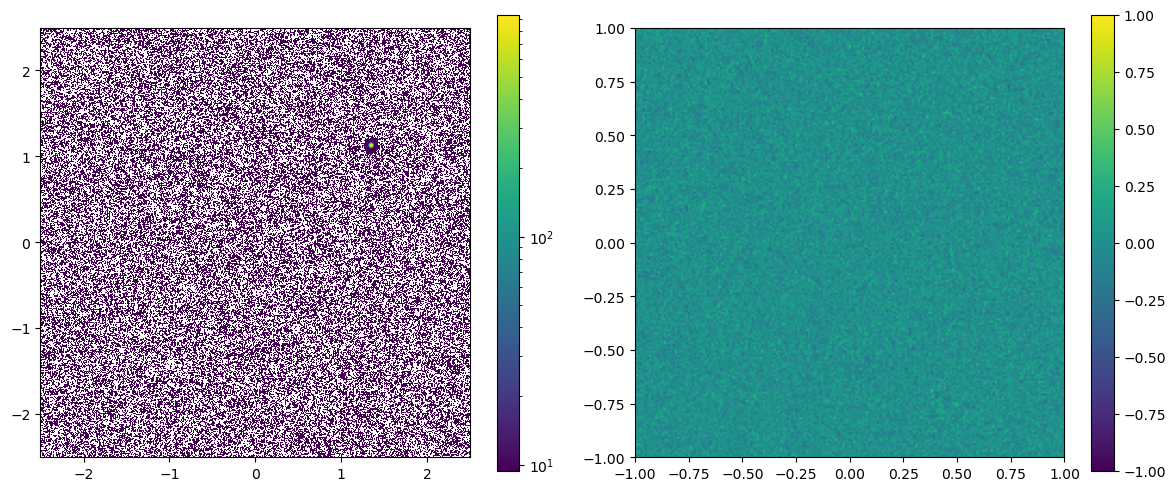

In [5]:
image = exp_result.detector_images[0]
extent = [
    exp_result.qranges['x'][0] - exp_result.dqs['x'] / 2.0,
    exp_result.qranges['x'][1] + exp_result.dqs['x'] / 2.0,
    exp_result.qranges['y'][0] - exp_result.dqs['y'] / 2.0,
    exp_result.qranges['y'][1] + exp_result.dqs['y'] / 2.0
]  # (left, right, bottom, top)


plt.figure(figsize=(12,5))

# summation
plt.subplot(121)
plt.imshow(
    image, origin='lower', extent=extent,
    norm=LogNorm(vmin=image.max() / 1e2, vmax=image.max())
)
plt.colorbar()

# zoom-in
plt.subplot(122)
plt.imshow(
    image, origin='lower', extent=extent
)
plt.colorbar()
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.clim(-1.0, 1.0)

plt.tight_layout()

### summed image

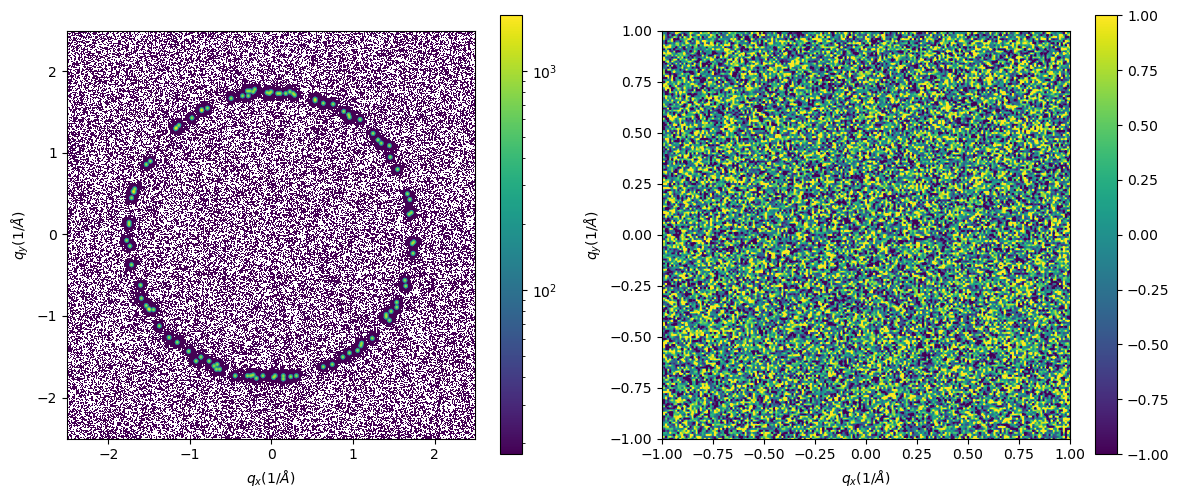

In [6]:
image = exp_result.detector_images.sum(axis=0)
extent = [
    exp_result.qranges['x'][0] - exp_result.dqs['x'] / 2.0,
    exp_result.qranges['x'][1] + exp_result.dqs['x'] / 2.0,
    exp_result.qranges['y'][0] - exp_result.dqs['y'] / 2.0,
    exp_result.qranges['y'][1] + exp_result.dqs['y'] / 2.0
]  # (left, right, bottom, top)


plt.figure(figsize=(12,5))

# summation
plt.subplot(121)
plt.imshow(
    image, origin='lower', extent=extent,
    norm=LogNorm(vmin=image.max() / 1e2, vmax=image.max())
)
plt.colorbar()
plt.xlabel('$q_x (1/\AA$)')
plt.ylabel('$q_y (1/\AA$)')

# zoom-in
plt.subplot(122)
plt.imshow(
    image, origin='lower', extent=extent
)
plt.colorbar()
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.clim(-1.0, 1.0)
plt.xlabel('$q_x (1/\AA$)')
plt.ylabel('$q_y (1/\AA$)')

plt.tight_layout()

Since the area of $-1 \leq q_x \leq 1, -1 \leq q_y \leq 1$ includes no Bragg spots, the standard deviation of detector noise can be estimated by using this area.

# Procedure
## find blobs of spots

1. set an area threshold $T_{area}$.
1. estimate a standard deviation of detector noise ($\sigma_{BG}$) from the center region of the image.
1. set the intensity threshold $T_{int} = 6\sigma_{BG}$.
1. generate a list of blobs indicating pixels with a value above $T_{int}$.
1. update the list by removing the blobs with an area smaller than $T_{area}$.

## estimate the spot position

1. get pixel coordinates $\{(x,y) \in Blob\}$.
1. calculate an average of pixel coordinates by using the pixel values as the weight.

## estimate the center of image

1. define a cost function $L(x_0, y_0)$, where $(x_0, y_0)$ is the center coordinate of image to estimate.
1. minimize $L(x_0, y_0)$.

## cost function

$L(x_0, y_0) = \langle(\Delta r_j(x_0, y_0))^2\rangle_j,$

$\Delta r_j(x_0, y_0) = r_j(x_0, y_0) - \bar{r}(x_0, y_0),$

$r_j(x_0, y_0) = \sqrt{(x_j - x_0)^2 + (y_j - y_0)^2},$

$\bar{r}(x_0, y_0) = \langle r_j(x_0, y_0) \rangle_j.$

Here $\langle X_j \rangle_j$ is the average of $\{X_j\}_j$ in terms of $j$.

# main

In [7]:
def find_blobs(
    image: np.ndarray,
    intensity_threshold: float,
    area_threshold: float
) -> np.ndarray:
    """
    find blobs of spots. The blobs will be obtained by the following procedure:
    
    1. generate a list of blobs indicating pixels with a value above intensity_threshold.
    1. update the list by removing the blobs with an area smaller than area_threshold.
    
    Parameters
    ----------
    image : numpy.ndarray
        image with spots.
    intensity_threshold : float
        threshold of spot signals.
    area_threshold : float
        threshold of spot area.
    
    Returns
    -------
    a list of blobs (r, c, sigma = radius/2**0.5) (numpy.ndarray).
    """
    image_ = (image > intensity_threshold).reshape(image.shape)
    
    # generate a list of blobs
    blobs = blob_dog(image_, threshold=0.1)
    
    # remove small-area blobs
    blobs_area = np.pi * 2. * blobs[:, 2]**2
    blobs = blobs[blobs_area>=area_threshold]
    return blobs


def estimate_spot_positions(image: np.ndarray, blobs: np.ndarray) -> np.ndarray:
    """
    estimate spot positions. The spot positions will be obtained by the following procedure:
    
    1. select a blob from the input blobs.
    1. get the coordinates in the blob.
    1. calculate an average of pixel coordinates by using the pixel values in the input image as the weight.
    
    Parameters
    ----------
    image : numpy.ndarray
        an image.
    blobs : numpy.ndarray
        a list of blobs (r, c, sigma = radius/2**0.5).
        This input is supposed to be obtained by using `scipy.feature.blob_dog`.

    Returns
    -------
    a list of spot positions (y, x) (numpy.ndarray).
    """
    # preparation
    image_ = image.flatten()
    xx, yy = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    xx = xx.flatten()
    yy = yy.flatten()
    
    # main
    positions = np.zeros((blobs.shape[0], 2))
    for ii in range(blobs.shape[0]):
        # get blob parameters
        r, c, s = blobs[ii]
        
        # get the coordinates in the blob
        ind = (xx - c)**2 + (yy - r)**2 <= 2.0 * s**2

        # calculate the spot position
        denominator = image_[ind].sum()
        x_center = (xx[ind] * image_[ind]).sum() / denominator
        y_center = (yy[ind] * image_[ind]).sum() / denominator
        positions[ii] = np.array([y_center, x_center])

    return positions


def cost_function(x0, coors: np.ndarray):
    """
    cost funciton
    
    Parameters
    ----------
    x0 : 1D aray-like
        initial center coordinates (y0, x0).
    coors : 2D array-like
        coordinates (y, x).

    Returns
    -------
    calculated value (float).
    """
    r_j = ((coors[:, 0] - x0[0])**2 + (coors[:, 1] - x0[1])**2)**0.5
    return r_j.std(ddof=1)

In [8]:
%%time

intensity_threshold = 0.6
area_threshold = 20.

spots_position = []
for image in exp_result.detector_images:
    blobs = find_blobs(image, intensity_threshold, area_threshold)
    positions = estimate_spot_positions(image, blobs)
    for position_coor in positions:
        spots_position.append(position_coor)

spots_position = np.array(spots_position)

CPU times: user 47.7 s, sys: 2.44 s, total: 50.2 s
Wall time: 50.2 s


In [9]:
x0 = (image.shape[0]//2, image.shape[1]//2)

res = minimize(cost_function, x0, args=(spots_position,)) 

In [10]:
res, type(res)

(      fun: 1.9659591583033758
  hess_inv: array([[ 3.30841573, -0.07734026],
        [-0.07734026,  4.63297434]])
       jac: array([ 2.23517418e-07, -1.34110451e-07])
   message: 'Optimization terminated successfully.'
      nfev: 24
       nit: 7
      njev: 8
    status: 0
   success: True
         x: array([249.8437422 , 249.54318347]),
 scipy.optimize._optimize.OptimizeResult)

almost same as the center of array.

## output

In [11]:
import pickle

output_fpath = os.path.join("../output_data", "result.pickle")

with open(output_fpath, "wb") as ff:
    pickle.dump(res, ff)

## check the result

In [12]:
res_ = None
with open(output_fpath, "rb") as ff:
    res_ = pickle.load(ff)

res_

      fun: 1.9659591583033758
 hess_inv: array([[ 3.30841573, -0.07734026],
       [-0.07734026,  4.63297434]])
      jac: array([ 2.23517418e-07, -1.34110451e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([249.8437422 , 249.54318347])